# **Import**

In [ ]:
import os
import h5py
import turtle
import random
import matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple
from math import cos, sin, radians , exp, sqrt
print("GPUs : ", tf.config.list_physical_devices('GPU'))

GPUs :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

#**Ce qu'il me reste à faire :**

*   **WIP :** Changer le support Render() Turtle vers autre librairie

*   **WIP :** optimiser le programme( surtout l'environnement) et fusionner les classes pouvant l'être

*   **WIP :** Utiliser le GPU voir TPU si possible

*   **WIP :** débloquer l'implementation des obstacles

*   **WIP :** généraliser le programme

# **Paramètres**

In [ ]:
class para:
    """
    Classe de tous les paramètres modifiables
    """
        # hyperparamètres de l'agent :      
    episodes = 700                      # nb d'épisode d'entrainement

    dueling = True                      # True si mise en place de double dueling networks
    tau_update=True
    dir="model"
    save = False
    modeload = False

        # données de compilation
    LearningRate = 1e-3
    opti=tf.keras.optimizers.RMSprop(learning_rate=LearningRate, rho=0.95, epsilon=0.01)    # meilleur pour l'instant c RMSPROP [RMSprop(lr=self.learning_rate, rho=0.95, epsilon=0.01]
    loss=tf.keras.losses.CategoricalCrossentropy()                                          # meilleur pour l'instant c categorical crossentropy
    metrique=[tf.keras.metrics.CategoricalCrossentropy()]                                   # meilleur pour l'instant c categorical crossentropy
    initializer= tf.keras.initializers.Ones()

        # exploration ou exploitation
    eps_st = 1
    eps_end = 0.01
    eps_decay = 0.001

        #gestion du target+Memoire
    target_update = 16                  #nombre de tour entre chaque actualisation du target net
    memory_size = 20000                  #taille de la Replay memory
    batch_size = 64                     #taille du batch de Replay memory sur lequel j'entraine le modèle à chaque tour
    batchsize = 32                      # taille du batch fit
    tau=0.1
    PER_epsi = 0.01
    PER_alpha = 0.6

        #variables d'environnement : 
    renderfull=False                    # True fait en sorte que je puisse voir en temps réel le chemin
    render = False
    gamma = 0.999                       # taux de diminution de la récompense

    A = [0,0]
    B = [30,0]
    size= [(abs(B[0])+abs(B[1]))*2+2,(abs(B[0])+abs(B[1]))*2+2,2]
    astar = (2**(6*int(np.log10(sqrt(B[0]**2 + B[1]**2)) )))-1
    print(astar)
    print(size)

    def_step = 400                      # le nombre maximal de pas authorisé par tour
        
    obstacles = [[20,-56],[120,12]]
    obstacles_size = [50,30]

        
        #donnes de l'agent
    limit = (B[0]**2 + B[1]**2)*4       # la limite de distance au carré 
    actionspace = 4                     # me donne le nombre de déplacements possibles ( 4 = 90 °) nb/360 = nb de degré de Delta
    j = 1                               # la taille des pas que je fais

        #données d'apprentissage/ de visulisation des données

    nb_objets=1                         # le nombre d'objets différents (turtle,obstacle,pointB,A,etc)
    M = 5                               # j'aurai la moyenne des M derniers nombres mouvements sur le plot
    M2 = 20                             # j'aurai la proportion des M2 dernières fins réelles sur le plot

63
[102, 102, 2]


# **Matplot**

In [ ]:
def plot (values,period,what):
    """
    sert à afficher les données de façon clean
    """
    if what == 0 : 
        if is_ipython: display.clear_output(wait=True)
    plt.figure(2)
    plt.clf()
    if what ==0:
        plt.title("Training")
        plt.xlabel("Episode")
        plt.ylabel("Duration")
    elif what==1:
        plt.title("Evaluation des fins réelles")
        plt.xlabel("Episode")
        plt.ylabel("statut de la fin")
    plt.plot(values)

    moving_avg = get_moving_average(values,period)
    
    plt.plot(moving_avg)
    plt.pause(0.001)
    return moving_avg

def get_moving_average(valeurs,period):
    if len(valeurs)>= period:
        return np.insert(pd.Series(valeurs).rolling(window=period).mean().iloc[period-1:].values,0,[0]*(period-1))
    else:
        return np.zeros(len(valeurs))

# **Classe DQN**

In [ ]:
class DQN(tf.Module):  
    """
    création d'un réseau de neurone profond 
    """
    def __init__(self,inputnb,actionspace,ler,named,dir,opti,lossing,metrique,dueling,tau,tau_update,initializer):
        self.tau_update=tau_update
        self.dueling=dueling
        self.TAU = tau
        if not dueling:
            self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=3,kernel_size=2, strides=1, activation='relu',input_shape=(inputnb[0],inputnb[1],inputnb[2])),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=1, padding='valid'),
            tf.keras.layers.PRelu(),
            tf.keras.layers.Conv2D(filters=2,kernel_size=2, strides=2, activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'),
            tf.keras.layers.PReLU(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1024,activation="elu", kernel_initializer=initializer),
            tf.keras.layers.Dense(512, activation="elu", kernel_initializer=initializer),
            tf.keras.layers.Dense(256, activation='elu', kernel_initializer=initializer),
            tf.keras.layers.Dense(128, activation='elu', kernel_initializer=initializer),
            tf.keras.layers.Dense(64,  activation='elu', kernel_initializer=initializer),
            tf.keras.layers.Dense(32,  activation='elu', kernel_initializer=initializer),
            tf.keras.layers.Dense(actionspace, activation='linear', kernel_initializer=initializer)])

            self.model.compile(optimizer=opti, loss=lossing, metrics=metrique)
            self.model.summary()
        else:
            input=tf.keras.layers.Input(shape=inputnb,name="Input")

            convo = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters=3,kernel_size=2, strides=1, activation="relu",input_shape=(inputnb[0],inputnb[1],inputnb[2])),
                tf.keras.layers.MaxPool2D(pool_size=2, strides=1, padding="valid"),
                tf.keras.layers.Conv2D(filters=2,kernel_size=2, strides=2, activation="relu"),
                tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding="valid"),
                tf.keras.layers.PReLU(),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1024,activation="relu", kernel_initializer=initializer)],name="Convolution")(input)

            value_net = tf.keras.Sequential([
                tf.keras.layers.Dense(128,activation="relu", kernel_initializer=initializer),
                tf.keras.layers.Dense(1, kernel_initializer=initializer),
                tf.keras.layers.Lambda(lambda s: tf.keras.backend.expand_dims(s[:, 0], -1),output_shape=(actionspace,))],name="Value_network")(convo)

            advantage_net = tf.keras.Sequential([ 
                tf.keras.layers.Dense(128, activation="relu", kernel_initializer=initializer),
                tf.keras.layers.Dense(actionspace, kernel_initializer=initializer),
                tf.keras.layers.Lambda(lambda a: a[:, :] - tf.keras.backend.mean(a[:, :], keepdims=True),output_shape=(actionspace,))],name="Advantage_network")(convo)

            output = tf.keras.layers.Add()([value_net, advantage_net])

            """distance_net = tf.keras.Sequential([
                tf.keras.layers.Dense(128),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(actionspace)])(input)
            net = tf.keras.layers.Concatenate()([Resnet,distance_net])"""

            


            self.model = tf.keras.Model(input, output,name=named)
            self.model.compile(optimizer=opti, loss=lossing, metrics=metrique)
            tf.keras.utils.plot_model(self.model, to_file='réseau.png')
            self.model.summary()

        if not os.path.exists(dir): os.makedirs(dir)
        self.saveplace = os.path.join(dir,named+".h5") 

    def tautransfer(self,policy_model):
        if not self.tau_update:
            self.transfer(policy_model)
        else:
            q_model_theta = policy_model.get_weights()
            target_model_theta = self.model.get_weights()
            i = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[i] = target_weight
                i += 1
            self.model.set_weights(target_model_theta)

    def transfer(self,model):
        self.model.set_weights(model.get_weights())

    def fitting(self,target_net,gammaparam,batchsize,memory,batch_size):
        experiences = memory.sample(batchsize)
        states, actions, rewards , next_states, dones = extract_tensors(list(zip(*experiences))[1])

        target = tf.squeeze(self.model.predict(states)).numpy()
        target_next = tf.squeeze(self.model.predict(next_states)).numpy()
        target_val = tf.squeeze(target_net.predict(next_states)).numpy()

        erreur = np.zeros(batchsize)
        for i in range(batchsize):
            val = target[i][actions[i]]
            if dones[i]: target[i][actions[i]] = rewards[i]
            else:target[i][actions[i]] = gammaparam * target_val[i][np.argmax(target_next[i])] + rewards[i]
            erreur[i] = abs(val - target[i][actions[i]])
        
        for i in range(param.batch_size):
            idx = experiences[i][0]
            memory.update(idx, erreur[i])
    
        self.model.fit(states, tf.constant(target), batch_size=batch_size,sample_weight=None,verbose=0, epochs=3)
        
    
    def load(self):
        print("------------CHARGEMENT MODELE------------")
        try:
            self.model = tf.keras.models.load_model(self.saveplace)
            print("--------------MODELE CHARGE--------------")
        except Exception as ex: print("échec du chargement : ",ex)

    def save(self):
        print("----------ENREGISTREMENT MODELE----------")
        try: 
            self.model.save(self.saveplace) 
            print("------------MODELE ENREGISTRE------------")
        except Exception as ex: print("échec de l'enregistrement : ",ex)

# **Experience et arbre binaire**


In [ ]:
Experience = namedtuple("Experience",("state","action","reward","next_state","done"))

In [ ]:
class SumTree:
    write = 0
    """
    crée un arbre binaire (bibliothèque venant de Github)
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2*capacity - 1)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        parent = (idx - 1)//2
        self.tree[parent] += change
        if parent != 0: self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree): return idx
        if s <= self.tree[left]: return self._retrieve(left, s)
        else: return self._retrieve(right, s-self.tree[left])

    def add(self, p, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, p)
        self.write += 1
        if self.write >= self.capacity: self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]
        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[dataIdx])

# **Mémoire**

In [ ]:
class Replay_memory():
    """
    Je gère la mémoire 
    """
    def __init__(self,capa,a,e):
        self.tree = SumTree(capa)
        self.e = e
        self.a = a

    def add(self, experience, policynet, targetnet,gamma):
        state, action, reward , next_state, done = extract_tensors([experience])

        target = policynet(state).numpy()
        target_next = policynet(next_state).numpy()
        target_val = targetnet(next_state).numpy()

        val = target[0][action[0]]
        if done[0]: target[0][action[0]] = reward[0]
        else:target[0][action[0]] = gamma * target_val[0][np.argmax(target_next[0])] + reward[0]
        erreur = abs(val - target[0][action[0]])
        self.tree.add((erreur + self.e) ** self.a, experience)

    def sample(self, n):
        batch = []
        moyenne = self.tree.tree[0] / n
        for i in range(n):
            a = moyenne * i
            b = moyenne * (i + 1)
            idx, p, data = self.tree.get(random.uniform(a, b))
            batch.append([idx, data])
        return batch

    def update(self, idx, error):
        self.tree.update(idx, (error + self.e) ** self.a)

# **Politique EpsilonGreedy**

In [ ]:
class Greedy():
    """
    Me donne la politique en matière d'exploration/ Exploitation ( via le facteur *Epsilon)
    """
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_explo_rate(self, current_step):
        return self.end + exp(-1. * self.decay * current_step) * (self.start - self.end)

# **Agent décisionnel**

In [ ]:
class Agent():
    """
    Agent décisionnel (me donne l'action à faire) (MDP)
    """
    def __init__(self,strategy,num_actions):
        self.num_actions = num_actions
        self.current_step = 0
        self.strategy = strategy
    
    def select_action(self,state,policy_net):
        rate = self.strategy.get_explo_rate(self.current_step)
        self.current_step +=1

        if rate > random.random():
            return random.randrange(self.num_actions)
        else:
            return ((tf.squeeze(tf.math.argmax(policy_net.model(tf.expand_dims(state,0)),axis=1))).numpy())

# **Classe Environnement**

In [ ]:
class ENV:   
    """
    l'environnement, mon agent, ses caractéristiques
    """
    def __init__(self,A,B,j,Max_steps,obsta,size,actionspace,limit,initset,nb_objet):
        self.actions_space = actionspace
        self.posA = A
        self.posB = B
        self.state = [A[0],A[1]]
        self.j = j
        self.path = [A]
        self.etape = 0
        self.stepmax = Max_steps
        self.obstacles = obsta
        self.nb_objets = nb_objet
        self.size = size
        self.initset = initset
        self.perte = -100/(size[0]*size[1])
        self.done = False

        if initset:
            screen = turtle.Screen()
            screen.title("Chemin le plus court")
            self.bob= turtle.Turtle()
            self.bob.pos = self.posA
            self.bob.speed(0)
            self.bob.pu()
            self.bob.goto(self.posA[0], self.posA[1])
            self.bob.pd()
            self.Acr(self.posA[0],self.posA[1])
            self.Bcr(self.posB[0],self.posB[1])
            self.obstacle_Spawn()

    def Acr(xa,ya):
        A = turtle.Turtle()
        A.speed(0)
        A.pu()
        A.color("red")
        A.shape("square")
        A.shapesize(stretch_wid=1,stretch_len=1)
        A.goto(xa,ya)

    def Bcr(xb,yb):
        B = turtle.Turtle()
        B.pu()
        B.speed(0)
        B.color("blue")
        B.shape("square")
        B.shapesize(stretch_wid=1,stretch_len=1)
        B.goto(xb, yb)

    def obstacle_Spawn(self):
        for w in range (0,len(self.obstacles)):
            obstacle = turtle.Turtle()
            obstacle.speed(0)
            obstacle.pu()
            obstacle.shape("square")
            obstacle.color("brown")
            obstacle.shapesize(stretch_wid=5, stretch_len=3)
            obstacle.goto(self.obstacles[w][0],self.obstacles[w][1])

    def Astar(self):
        x=[]
        for i in range(self.actions_space): x.append(((self.state[0]+self.j*cos(radians((360/self.actions_space)*i))-self.posB[0])**2+(self.state[1]+self.j*sin(radians((360/self.actions_space)*i))-self.posB[1])**2))
        return np.argmin(x)

    def render(self): # n'est utliser que si initset était true
        if self.initset == True:
            self.bob.goto(self.state[0],self.state[1])
        else:
            print ("impossible d'afficher une donnée")

    def renderfull(self):  # je render tout le chemin d'une turtle
        print(self.path)
        screen = turtle.Screen()
        screen.title("Chemin le plus court")
        self.bob= turtle.Turtle()
        self.bob.pos = self.posA
        self.bob.speed(1)
        self.bob.pu()
        self.bob.goto(self.posA[0], self.posA[1])
        self.bob.pd()
        self.Acr(self.posA[0],self.posA[1])
        self.Bcr(self.posB[0],self.posB[1])
        self.obstacle_Spawn()
        self.bob.goto(self.path[-1])
        self.bob.pencolor("red")
        for i in range (1,len(self.path)):            # je repasse en allant seulement sur les cases validées 
            self.bob.goto(self.path[-i])
        turtle.done()

    def get_state(self):
        stat = np.zeros(self.size)
        stat[self.state[0]][self.state[1]][0] = 1
        stat[self.posB[0]][self.posB[1]][1] = 10
        return tf.constant(stat,dtype=float)

    def take_action(self,action):
        reward= self.step(action)
        return (reward,self.done)

    def reset(self):
        self.etape = 0
        self.path = [[self.posA[0],self.posA[1]]]
        self.state = [self.posA[0],self.posA[1]]
        return (self.posA)

    def close():
        turtle.bye()

    def step(self,action):
        self.state[0]+= int(self.j*cos(radians((360/self.actions_space)*action)))
        self.state[1]+= int(self.j*sin(radians((360/self.actions_space)*action)))

        self.distance = (self.state[0]-self.posB[0] )**2  + ( self.state[1]-self.posB[1] )**2
        ''' # Implementation de la gestion d'obstacles
        for i in range(0,len(self.obstacles)):
            if( (    abs(self.state[0] - self.obstacles[i][0]) <=30 ) and (  abs( self.state[1] - obstacles[i][1]) <=50  )):
                reward = -50
                break 
        '''
        if (self.distance <= self.j**2):
            self.state = self.posB
            reward = 1000
            self.etape = self.stepmax
            self.path.append(self.posB)
        else:
            reward = self.perte
            self.path.append(self.state)

        self.etape +=1     # j'ajoute 1 à l'étape puis vérifie si le nombre maximal d'étape pas simulation est atteint ou lorsque l'objet atteint B 

        if (self.etape >= self.stepmax ):self.done = True
        else: self.done = False

        if self.state[0]>=self.size[0]-3 or self.state[1]>=self.size[1]-3 or self.state[0]<=-(self.size[0]-3) or self.state[1]<=-(self.size[1]-3):
            reward = -10000

        if self.state[0]>=self.size[0]-1 or self.state[1]>=self.size[1]-1 or self.state[0]<=-(self.size[0]-1) or self.state[1]<=-(self.size[1]-1):
            self.done = True
            reward = -10000

        return reward

# **extraction tenseur**

In [ ]:
def extract_tensors(experiences):
    """
    J'extrais 5 tenseurs à partir d'un named tuples experiences 
    """
    batch = Experience(*zip(*experiences))
    t1 = tf.concat([batch.state],-1)
    t2 = np.concatenate([batch.action],-1)
    t3 = np.concatenate([batch.reward],-1)
    t4 = tf.concat([batch.next_state],-1)
    t5 = np.concatenate([batch.done],-1)
    return(t1,t2,t3,t4,t5)

# **Main**

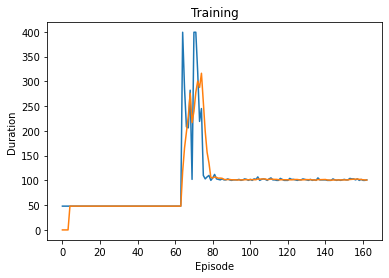

Episode : 163
moyenne mobile des 5 épisodes : 100.6
vraie fin : 65 
soit : 39.87730061349693 % 
pas numéro : 0 :: state : 0 | 1 :: reward : -0.009611687812379853 :: policy = [-0.06386743  0.33974713 -0.21414529 -0.11941838]
pas numéro : 25 :: state : 0 | 26 :: reward : -0.009611687812379853 :: policy = [-0.06386743  0.33974713 -0.21414529 -0.11941838]
pas numéro : 50 :: state : 0 | 51 :: reward : -0.009611687812379853 :: policy = [-0.06386743  0.33974713 -0.21414529 -0.11941838]
pas numéro : 75 :: state : 0 | 76 :: reward : -0.009611687812379853 :: policy = [-0.06386743  0.33974713 -0.21414529 -0.11941838]


KeyboardInterrupt: ignored

In [ ]:
if __name__ == "__main__":
    param = para()
    end = 0
    endingpoint=[]
    policy_net = DQN(param.size,param.actionspace,param.LearningRate,"Policy",param.dir,param.opti,param.loss,param.metrique,param.dueling,param.tau,param.tau_update,param.initializer)
    target_net = DQN(param.size,param.actionspace,param.LearningRate,"Target",param.dir,param.opti,param.loss,param.metrique,param.dueling,param.tau,param.tau_update,param.initializer)
    if param.modeload:policy_net.load()
    target_net.transfer(policy_net.model)

    env = ENV(param.A,param.B,param.j,param.def_step,param.obstacles,param.size,param.actionspace,param.limit,param.renderfull,param.nb_objets)
    greedy = Greedy(param.eps_st, param.eps_end,param.eps_decay)
    agent = Agent(greedy,env.actions_space)
    memory = Replay_memory(param.memory_size,param.PER_alpha,param.PER_epsi)

    episode_len = []

    for episode in range(param.episodes):
        
        env.reset()
        state = env.get_state()
        print("========================================================================================================")
        
        for pas in count():
            if param.render: env.render()
            if episode > param.astar : action = agent.select_action(state,policy_net)
            else:action = env.Astar()

            reward,done = env.take_action(action)
            next_state = env.get_state()
            memory.add(Experience(state,action,reward,next_state,done),policy_net.model,target_net.model,param.gamma)
            state = next_state
            policy_net.fitting(target_net.model,param.gamma,param.batch_size,memory,param.batchsize)
                
            if pas % 25 ==0 : print(f"pas numéro : {pas} :: state : {env.state[0]} | {env.state[1]} :: reward : {reward} :: policy = {tf.squeeze(policy_net.model(tf.expand_dims(state,0))).numpy()}")

            if env.done:
                target_net.tautransfer(policy_net.model)
                if (reward==1000):
                    end+=1
                    endingpoint.append(1)
                else:
                    endingpoint.append(0)

                episode_len.append(pas)
                move_avg = plot(episode_len, param.M,0)
                print(f"Episode : {episode+1}\nmoyenne mobile des {param.M} épisodes : {move_avg[-1]}\nvraie fin : {end} \nsoit : {(end/(episode+1))*100} % " )
                break
            if not param.tau_update:
                if episode%param.target_update==0:target_net.transfer(policy_net.model)
    
    if param.save:policy_net.save()


    _ = plot(endingpoint,param.M2,1)